<font size="5">Creación de la Grid para el Mapa de Bogotá</font>

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


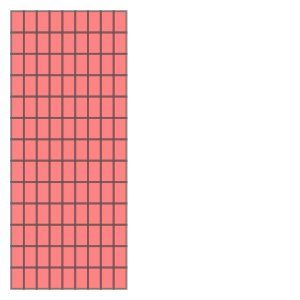

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import gmaps
import gmaps.datasets
import matplotlib.pyplot as plt
from pyproj import Proj

# Import necessary geometric objects from shapely module

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box
import fiona


# Create Point geometric object(s) with coordinates
point1 = Point(-74.2235814249999, 4.836779094841296)
point2 = Point(-73.98653427799991, 4.836779094841296)
point3 = Point(-73.98653427799991, 4.269664096859796)
point4 = Point(-74.2235814249999, 4.269664096859796)

# EPSG to which we are going to project (32718 also works)
nys = Proj(init='EPSG:3857') 

# Points projected in the new EPSG
p1_proj = nys(point1.x, point1.y)
p2_proj = nys(point2.x, point2.y)
p3_proj = nys(point3.x, point3.y)
p4_proj = nys(point4.x, point4.y)

# Length of the base and the height of the grid
longitud_base = Point(p1_proj).distance(Point(p2_proj))
longitud_altura = Point(p2_proj).distance(Point(p3_proj))

# Base and height size of each cell
b1 = 3000
h1 = 5000

# External grid where we locate the extreme points of the Bogota map
topLeft = p1_proj
topRight = Point(Point(p1_proj).x + math.ceil(longitud_base/b1)*b1, Point(p2_proj).y)
bottomRight = Point(topRight.x, Point(p2_proj).y - math.ceil(longitud_altura/h1)*h1)
bottomLeft = Point(Point(p1_proj).x, bottomRight.y) 

# Converting the grid to polygon
poligono_mayor = Polygon([topLeft, topRight, bottomRight, bottomLeft])


# Columns and rows of the grid
cols = np.linspace(np.array(bottomLeft)[0], np.array(bottomRight)[0], math.ceil(longitud_base/b1) + 1) 
rows = np.linspace(np.array(topLeft)[1], np.array(bottomLeft)[1], math.ceil(longitud_altura/h1) + 1)     

# Polygons of the cells that make up the grid
poligonos = [Polygon([Point(cols[i], rows[j]), Point(cols[i+1], rows[j]), Point(cols[i+1], rows[j+1]), 
                      Point(cols[i], rows[j+1]), Point(cols[i], rows[j])]) for i in range(len(cols)-1) 
             for j in range(len(rows)-1)]

poligonos_series = gpd.GeoSeries(poligonos)

grid = MultiPolygon(poligonos)
grid

<font size="5">Importación de los DataFrames de los Covariados Usados</font>

In [25]:
################## Dataframe con los poligonos de las localidades de Bogotá #################
# Mapa de las localidad de Bogotá (excluimos Sumapaz)
polig_loc_df = gpd.read_file('poligonos-localidades.geojson')
polig_loc_df = polig_loc_df.drop([2]).reset_index()
polig_loc_df = polig_loc_df.to_crs("EPSG:3857")

# Mapa de las UPZ de Bogotá
poligonos_upz_df =  gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/e1c11929-1b57-4900-8cae-0d236123b40a/resource/806a7752-c73d-4643-aaf0-ce88ab659bae/download/upla.json')
poligonos_upz_df = poligonos_upz_df.to_crs("EPSG:3857") 

# Como la columna 'UPlCodigo' tiene letras y el código de la UPZ, entonces eliminamos las letras
def dejar_solo_cifras(txt):
  return "".join(c for c in txt if c.isdigit())
poligonos_upz_df['UPlCodigo'] = poligonos_upz_df['UPlCodigo'].map(dejar_solo_cifras)


################## DATAFRAME DE LOS RESTAURANTES Y BARES EN BOGOTÁ 2019 #################
# Se entiende por establecimientos gastronómicos, bares y similares aquellos establecimientos comerciales en cabeza de 
# las personas naturales o jurídicas, cuya actividad económica esté relacionada con la producción, servicio y venta de
# alimentos y/o bebidas para consumo. Además, podrán prestar otros servicios complementarios.
rest_bar_df = gpd.read_file("https://datosabiertos.bogota.gov.co/dataset/b0c66a77-3230-4d0c-a119-dead7f9b8b8e/resource/9c3829e3-6b4b-4aac-a3e5-297fe0127b67/download/egba.geojson")
rest_bar_df = rest_bar_df.to_crs("EPSG:3857")

################## DATAFRAME DE LAS ESTACIONES DE POLICIA EN BOGOTÁ 2020 #################
# Es la unidad básica de la organización policial cuya jurisdicción corresponde a cada municipio, en el que se divide 
# el territorio nacional, sin perjuicio que en un Municipio funcionen varias estaciones. En Bogotá las estaciones 
# corresponden a las localidades que integran el Distrito Capital.
est_pol_df = gpd.read_file("https://datosabiertos.bogota.gov.co/dataset/01cf1c3e-e077-4d38-86e6-bda3ff6cd645/resource/eae94a3a-034f-48c7-98a6-8aa30c3805f8/download/estacionpolicia.geojson")
est_pol_df = est_pol_df.to_crs("EPSG:3857")

################## DATAFRAME CON LOS POLÍGONOS DE MONITOREO 2020 #################
#CONTIENE CARACTERÍSTICAS NO ENTENDIDAS (VALORES COMO ocutotal ENTRE OTROS) LOS CUALES PODRÍAN MEJORAR LA CALIDAD
#DEL DATASET. POR EL MOMENTO, SOLO UTILIZAREMOS EL ÁREA INTERSECTADA
# El set de datos contiene información de las áreas o territorio identificados como una zona susceptible o en proceso 
# de desarrollo ilegal, ya sea por asentamiento o enajenación; los cuales son objeto de vigilancia y seguimiento para 
# adelantar labores de prevención a la ocupación y al desarrollo ilegal en el marco de las competencias de la SDHT.
pol_mon_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/xt98-rz23?method=export&format=GeoJSON')
#pol_mon_df['centroid'] = pol_mon_df['geometry'].centroid
pol_mon_df = pol_mon_df.to_crs("EPSG:3857")

#########################  DATAFRAME DE COMANDO DE ATENCIÓN INMEDIATA 2020 ######################## 
# Unidad policial con recursos humanos y materiales asignados a una jurisdicción, que en forma organizada con la comunidad 
# y a través de la instrucción permanente, busca la solución de problemas de seguridad, con el objetivo de fraternizar 
# y unir la policía con la comunidad.
com_at_df =  gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/bcc51101-762b-4e13-9455-f77502c75a0f/resource/202c5810-6880-43f8-b801-df70aaf6d237/download/comandoatencioninmediata.geojson')
com_at_df = com_at_df.to_crs("EPSG:3857")

#########################  DATAFRAME DE CUADRANTES DE POLICÍA 2020 ######################## 
# Es un sector geográfico fijo, que a partir de sus características sociales, demográficas y geográficas, recibe distintos tipos
# de atención de servicio policial, entre los cuales se cuentan la prevención, la disuasión, control de delitos y contravenciones 
# y la educación ciudadana en seguridad y convivencia.
cuadr_pol_df =  gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/b555594d-203e-4d34-8d17-32b13f94168b/resource/f0ad2ee3-bfd0-4825-9b31-bff9041649fa/download/cuadrantespolicia.geojson')
cuadr_pol_df = cuadr_pol_df.to_crs("EPSG:3857") 

######################### DATAFRAME DE INSPECCIONES DE POLICÍA 2020 ######################## 
# Institución adscrita a la Secretaría de Gobierno del Distrito que cumplen una función vital en la promoción de la convivencia 
# pacífica de la ciudad, se encargan de prevenir, conciliar, resolver los conflictos que surgen de las relaciones entre vecinos 
# y todos aquellos que afecten la tranquilidad, seguridad, salubridad, movilidad y el espacio público de los ciudadanos y sancionar 
# las conductas violatorias al Código de Policía de Bogotá.
insp_pol_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/828c088a-367b-441f-a008-fa98fa6f5e13/resource/9d6daeff-1c62-457a-bfd7-d03dba3aef85/download/inspeccionpolicia.geojson')
insp_pol_df =  insp_pol_df.to_crs("EPSG:3857")

######################## DATAFRAME DE LOS CENTROS COMERCIALES 2020 ######################## 
# Son espacios comerciales administrados por el IPES y ubicados estratégicamente en la Ciudad, en donde los vendedores 
# informales que ingresan a este servicio, realizan sus actividades comerciales en módulos, locales, restaurantes, 
# cafeterías y espacios; permitiendo así, la generación de ingresos, fortalecimiento económico y productivo del 
# ciudadano para hacer viable su ejercicio comercial y la inserción en el mercado formal de la ciudad. Su extensión 
# geográfica es el Distrito Capital de Bogotá en el área urbana.
cc_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/a690b981-4246-42c9-afa0-3125726ae9f2/resource/8efe71cb-fb12-4d63-a449-6fc06fbde27b/download/centro-comercial.csv', sep = ';', encoding='latin-1')
cc_df['coord_x'] = (cc_df['coord_x'].replace(',','.', regex=True).astype(float))
cc_df['coord_y'] = (cc_df['coord_y'].replace(',','.', regex=True).astype(float))
cc_df = gpd.GeoDataFrame(cc_df, geometry=gpd.points_from_xy(cc_df.coord_x, cc_df.coord_y),crs="EPSG:3857")
for i in range(0,len(cc_df)):
    cc_df['geometry'][i] = Point(nys(cc_df.geometry.iloc[i].x, cc_df.geometry.iloc[i].y))

cc_df = cc_df.drop([0], axis=0).reset_index()

######################### DATAFRAME DE LAS FERIAS INSTITUCIONALES 2020 ######################## 
# Son alternativas comerciales realizadas de forma permanente, creadas para re ubicar a vendedores informales que 
# ocupan el espacio público de la ciudad, mitigando el impacto que estas personas generan en la movilidad de la ciudad. Las ferias cuentan con servicio de baño, vigilancia privada y mobiliario compuesto por carpas para la venta de: ropa, calzado, antigüedades y artículos de segunda mano, entre otros. Su extensión geográfica es el Distrito Capital de Bogotá en el área urbana.
# NOTA: TIENE 3 ELEMENTOS
fer_inst_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/36409df7-da26-4dd3-8f65-352918263dab/resource/a7bd1f96-702b-4f77-a636-444f72ccceef/download/feria-institucional.csv', sep = ';', encoding='latin-1')
fer_inst_df['coord_x'] = (fer_inst_df['coord_x'].replace(',','.', regex=True).astype(float))
fer_inst_df['coord_y'] = (fer_inst_df['coord_y'].replace(',','.', regex=True).astype(float))
fer_inst_df = gpd.GeoDataFrame(fer_inst_df, geometry=gpd.points_from_xy(fer_inst_df.coord_x, fer_inst_df.coord_y))
for i in range(0,len(fer_inst_df)):
    fer_inst_df['geometry'][i] = Point(nys(fer_inst_df.geometry.iloc[i].x, fer_inst_df.geometry.iloc[i].y))

######################### DATAFRAME DE LAS PLAZAS DE MERCADOS 2020 ######################## 
# Las Plazas de Mercado encuentran su origen en pueblos o ciudades intermedias, donde eran el centro de comercio, donde 
# familias y cultivadores del campo llegaban con sus cosechas a ofertarlas y adquirir sus productos para la semana o el 
# mes. Esta comercialización se convirtió en el motor de la principal economía de muchas regiones del país, incluida 
# Bogotá. Actualmente la ciudad cuenta con 19 Plazas públicas a cargo del IPES, tres de ellas son patrimonio arquitectónico
# de Bogotá (Perseverancia, Concordia y Cruces y fueron creadas durante el primer tercio del siglo XX); otras están en 
# trance de ser declaradas como tales, en razón de sus espléndidos diseños realizados por parte de reconocidos 
# arquitectos como Dicken Castro (cubierta Veinte de Julio). El IPES ha construido en esta administración un nuevo 
# modelo de gestión de plazas de mercado, orientada hacia la gobernanza, teniendo en cuenta los siguientes componentes: 
# infraestructura, mercadeo y comercialización, gestión ambiental y fomento a la participación. Lo anterior, con el 
# propósito de posicionarlas y recuperarlas para la ciudad como destinos turísticos, gastronómicos y culturales. 
# Su extensión geográfica es el Distrito Capital de Bogotá en el área urbana.
pl_merc_df = pd.read_csv('https://datosabiertos.bogota.gov.co/dataset/fd2a6046-5cc3-4acd-81ac-03fe5ef7d549/resource/910e4895-21c3-43b9-84c4-ed40f7e5409e/download/plazas-de-mercado.csv', sep = ';', encoding='latin-1')
pl_merc_df['coord_x'] = (pl_merc_df['coord_x'].replace(',','.', regex=True).astype(float))
pl_merc_df['coord_y'] = (pl_merc_df['coord_y'].replace(',','.', regex=True).astype(float))
pl_merc_df = gpd.GeoDataFrame(pl_merc_df, geometry=gpd.points_from_xy(pl_merc_df.coord_x, pl_merc_df.coord_y))
for i in range(0,len(pl_merc_df)):
    pl_merc_df['geometry'][i] = Point(nys(pl_merc_df.geometry.iloc[i].x, pl_merc_df.geometry.iloc[i].y))


#########################  DATAFRAME DE ESTABLECIMIENTOS DE ALOJAMIENTO Y HOSPEDAJE 2019 ######################## 
# Es el conjunto de bienes destinados por la persona natural o jurídica a prestar el servicio de alojamiento no permanente 
# inferior a 30 días, con o sin alimentación y servicios básicos y/o complementarios o accesorios de alojamiento, mediante }
# contrato de hospedaje.
aloj_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/2e8e8046-7033-4d4b-854c-59dd5ecd9d86/resource/318834c0-5d5f-44b5-8f36-ea3a5a8503c1/download/establecimiento_de_alojamiento_y_hospedaje_bogota_2018.geojson')
aloj_df = aloj_df.to_crs("EPSG:3857")

################## DATAFRAME DE LAS OCUPACIONES ILEGALES 2020 #################
# Contiene la información de los predios que tienen ocupaciones ilegales y que corresponden a los diferentes polígonos que están 
# siendo monitoreados por la Secretaría Distrital del Hábitat
ocup_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/fg89-k9ge?method=export&format=GeoJSON')
ocup_df = ocup_df.to_crs("EPSG:3857")

#########################  DATAFRAME DE LA TASA DE DESEMPLEO PARA UPZ 2020 ######################## 
# Muestra la relación porcentual entre el número de personas en búsqueda de empleo y la población económicamente activa 
# en el distrito Capital.
desempl_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/5f28bf88-7178-4472-9a5b-493a886cd86f/resource/db624c65-0763-4cee-9c44-ff3b4c8dc377/download/tgp.geojson')
desempl_df = desempl_df.to_crs("EPSG:3857")

################# DATAFRAME DE LOS LUGARES QUE SON ÁREA PROTEGIDA 2017 ################# 
# El objeto geográfico almacena la delimitación del sistema de áreas protegidas de Bogotá D.C., ubicadas tanto en el área urbana 
# como rural, consideradas en el Artículo 79 del Decreto 190 de 2004 como el conjunto de espacios con valores singulares para el 
# patrimonio natural del Distrito Capital, la Región o la Nación, cuya conservación resulta imprescindible para el funcionamiento 
# de los ecosistemas, la conservación de la biodiversidad y la evolución de la cultura en el Distrito Capital, las cuales, en 
# beneficio de todos los habitantes, se reservan y se declaran. Temáticamente da cuenta del orden y categoría del área protegida,
# nombre y acto administrativo de oficialización del área protegida y ubicación en el suelo urbano o rural.
ar_prot_df = gpd.read_file('https://www.datos.gov.co/api/geospatial/w7hd-7hdi?method=export&format=GeoJSON')
ar_prot_df = ar_prot_df.drop([51], axis=0).reset_index() # eliminamos esta fila porque genera error de topología
#ar_prot_df['centroide'] =  ar_prot_df.geometry.centroid
ar_prot_df = ar_prot_df.to_crs("EPSG:3857")

################ DATAFRAME DE TASA DE DESERCIÓN ESCOLAR EN COLEGIOS NO OFICIALES 2019 ################
# La tasa de deserción escolar no oficial se define como el cociente entre el número de alumnos que desertaron el curso en el que 
# estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + desertores) en este mismo periodo de 
# tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100. 
desesc_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/3bb8e3df-937e-49e6-879a-4c7ea9b5c0dd/resource/50776a20-2c79-49a6-8d61-a79b18826fb3/download/tasa_desercion_no_oficial_upz.geojson')
desesc_df = desesc_df.to_crs("EPSG:3857")

################ DATAFRAME DE TASA DE DESERCIÓN ESCOLAR EN COLEGIOS OFICIALES 2019 ################
# La tasa de deserción escolar oficial se define como el cociente entre el número de alumnos que desertaron el curso en el que 
# estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + desertores) en este mismo periodo de 
# tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100.
desescof_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/f716fd5a-6bfe-4a37-a750-c0927fa392ee/resource/4cc094e2-e280-46c2-a8b4-c6c44c295588/download/tasa_desercion_oficial_upz.geojson')
desescof_df = desescof_df.to_crs("EPSG:3857")

#########################  DATAFRAME DE LA INFORMALIDAD LABORAL FUERTE 2020 ######################## 
# Muestra la proporción de individuos que en el mercado laboral tienen una ocupación con un ingreso, pero no están inscritos en 
# los sistemas de salud en el régimen contributivo y tampoco no cotizan en un fondo de pensiones en el distrito Capital.
inf_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/77223828-6a8f-4bba-961a-5076f5951c7b/resource/84194761-ba34-4a18-8611-44794af08f0d/download/ilf.geojson')
inf_df = inf_df.to_crs("EPSG:3857")

######################### DATAFRAME DE TASA DE ASALARIADOS 2020 ######################## 
#Muestra la relación del total de individuos asalariados sobre el número total de personas ocupadas de la ciudad en el distrito
#Capital
tasal_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/5aa72143-59f6-47ee-971e-bd965dfa124f/resource/2d3f0db6-90cf-4ac4-b1ea-597c33dd0c61/download/ta.geojson')
tasal_df = tasal_df.to_crs("EPSG:3857")

########################## DataFrame de Manzanas-Estratificación 2019 #########################
#Son unidades geográficas tipo manzana a las cuales se les asocia la variable de estrato socioeconómico, siendo esta, 
#la clasificación de los inmuebles residenciales que deben recibir servicios públicos. Se realiza principalmente para 
#cobrar de manera diferencial por estratos los servicios públicos domiciliarios, permitiendo asignar subsidios y cobrar 
#contribuciones. (# 3982 # 24462 # 43310 # 43819 # 43971  PRESENTAN PROBLEMAS EN LA TOPOLOGÍA)
estrat_df = gpd.read_file('https://datosabiertos.bogota.gov.co/dataset/dd5c2af8-caeb-4ec1-8f66-28a2bad8cec1/resource/3486d1d2-c1d8-449e-a31c-74872a87f960/download/manzanaestratificacion.geojson')
estrat_df = estrat_df.to_crs("EPSG:3857")
estrat_df = estrat_df.drop([3982,24462,43310,43819, 43971], axis=0).reset_index()


################# DataFrame de la Demografía de las víctimas del conflicto armado #################
# Se encuentra la información de la población de víctimas del conflicto armado en el distrito capital a nivel UPZ y Localidad.

vict_df = gpd.read_file('Demografia_UPZ.geojson')
vict_df['UPZ'] = vict_df['UPZ'].apply(lambda x: x.upper()) 
# Con el fin de escribir el promedio de la columas (e.j. 'HOMBRES') de las victimas del conflicto armado  por UPZ
for i in range(3, 50):
    vict_df[np.array(vict_df.columns)[i]] = vict_df[np.array(vict_df.columns)[i]]/vict_df['TOTAL_PERS'].sum()

IncompleteRead: IncompleteRead(18297472 bytes read)

<font size="5">Creación del DataFrame poligonos_df.csv</font>

In [16]:
distance = np.sqrt(h1**2+b1**2)

poligonos_df = gpd.GeoDataFrame({'Poligono': poligonos})

###################
# Columnas del DF #
###################

poligonos_df['Coord Punto 1'] = ''
poligonos_df['Coord Punto 2'] = ''
poligonos_df['Coord Punto 3'] = ''
poligonos_df['Coord Punto 4'] = ''
poligonos_df['Coord del Centroide del Poligono'] = ''
poligonos_df['Círculo con radio R'] = ''

poligonos_df['Núm de Restaurantes y Bares 2019'] = ''
poligonos_df['Núm de Restaurantes y Bares en un radio R 2019'] = ''

poligonos_df['Núm de Estaciones de Policía 2020'] = ''
poligonos_df['Núm de Estaciones de Policía en un radio R 2020'] = ''

poligonos_df['Área de Poligonos Monitoreados 2020'] = ''
poligonos_df['Área de Poligonos Monitoreados en un radio R 2020'] = ''

poligonos_df['Núm de Comando de Atención Inmediata 2020'] = ''
poligonos_df['Núm de Comando de Atención Inmediata en un radio R 2020'] = ''

poligonos_df['Área de Cuadrantes de Policía 2020'] = ''
poligonos_df['Área de Cuadrantes de Policía en un radio R 2020'] = ''

poligonos_df['Núm de Inspecciones de Policía 2020'] = ''
poligonos_df['Núm de Inspecciones de Policía en un radio R 2020'] = ''

poligonos_df['Núm de Centros Comerciales 2020'] = ''
poligonos_df['Núm de Centros Comerciales en un radio R 2020'] = ''

poligonos_df['Núm de Ferias Institucionales 2020'] = ''
poligonos_df['Núm de Ferias Institucionales en un radio R 2020'] = ''

poligonos_df['Núm de Plazas de Mercado 2020'] = ''
poligonos_df['Núm de Plazas de Mercado en un radio R 2020'] = ''

poligonos_df['Núm de Establecimientos de Alojamiento y Hospedaje 2019'] = ''
poligonos_df['Núm de Establecimientos de Alojamiento y Hospedaje en un radio R 2019'] = ''

poligonos_df['Núm de Ocupaciones Ilegales 2020'] = ''
poligonos_df['Núm de Ocupaciones Ilegales en un radio R 2020'] = ''

poligonos_df['Promedio de Tasa Global de Participación 2011 (Tasa de Desempleo)'] = ''
poligonos_df['Promedio de Tasa Global de Participación 2014 (Tasa de Desempleo)'] = ''
poligonos_df['Promedio de Tasa Global de Participación 2017 (Tasa de Desempleo)'] = ''

poligonos_df['Área Protegida 2017'] = ''
poligonos_df['Área Protegida en un radio R 2017'] = ''

poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TRANSICIÓN) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TRANSICIÓN) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES PRIMERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES PRIMERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEGUNDO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEGUNDO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TERCERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TERCERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES CUARTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES CUARTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES QUINTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES QUINTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEXTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEXTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES SEPTIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES SEPTIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES OCTAVO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES OCTAVO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES NOVENO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES NOVENO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES DECIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES DECIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES ONCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES ONCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (TOTAL HOMBRES) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (TOTAL MUJERES) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES DOCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES DOCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (HOMBRES TRECE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios no oficiales (MUJERES TRECE) 2019'] = ''

poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES TRANSICIÓN) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES TRANSICIÓN) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES PRIMERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES PRIMERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEGUNDO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEGUNDO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES TERCERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES TERCERO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES CUARTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES CUARTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES QUINTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES QUINTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEXTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEXTO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES SEPTIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES SEPTIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES OCTAVO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES OCTAVO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES NOVENO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES NOVENO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES DECIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES DECIMO) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES ONCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES ONCE) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (TOTAL HOMBRES) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (TOTAL MUJERES) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (HOMBRES ACELERACIÓN) 2019'] = ''
poligonos_df['Porcentaje de deserción escolar-Colegios oficiales (MUJERES ACELERACIÓN) 2019'] = ''

poligonos_df['Promedio de la informalidad laboral fuerte 2011'] = ''
poligonos_df['Promedio de la informalidad laboral fuerte 2014'] = ''
poligonos_df['Promedio de la informalidad laboral fuerte 2017'] = ''

poligonos_df['Tasa Promedio de Asalariados 2011'] = ''
poligonos_df['Tasa Promedio de Asalariados 2014'] = ''
poligonos_df['Tasa Promedio de Asalariados 2017'] = ''

poligonos_df['Promedio Estrato 2019'] = ''

poligonos_df['Vict Hombres 2019'] = ''
poligonos_df['Vict Mujeres 2019'] = ''
poligonos_df['Vict Intersexual 2019'] = ''
poligonos_df['Vict Sin Info Sexo 2019'] = ''
poligonos_df['Vict Género Masculino 2019'] = ''
poligonos_df['Vict Género Femenino 2019'] = ''
poligonos_df['Vict Género Transgenerista 2019'] = ''
poligonos_df['Vict No Sabe Género 2019'] = ''
poligonos_df['Vict Sin Información Género 2019'] = ''
poligonos_df['Vict Afrocolombianos 2019'] = ''
poligonos_df['Vict Indígenas 2019'] = ''
poligonos_df['Vict Mestizos 2019'] = ''
poligonos_df['Vict Palenquero 2019'] = ''
poligonos_df['Vict Raizales 2019'] = ''
poligonos_df['Vict Room 2019'] = ''
poligonos_df['Vict Sin Info Étnia 2019'] = ''
poligonos_df['Vict Sin Pertenecer Étnica 2019'] = ''
poligonos_df['Vict No Pertenecen Étnica 2019'] = ''
poligonos_df['Vict Primera Infancia 2019'] = ''
poligonos_df['Vict Infancia 2019'] = ''
poligonos_df['Vict Adolescencia 2019'] = ''
poligonos_df['Vict Juventud 2019'] = ''
poligonos_df['Vict Adultez 2019'] = ''
poligonos_df['Vict Adulto Mayor 2019'] = ''
poligonos_df['Vict Discap Ali 2019'] = ''
poligonos_df['Vict Discap Camb 2019'] = ''
poligonos_df['Vict Discap Caminar 2019'] = ''
poligonos_df['Vict Discap Cognitva 2019'] = ''
poligonos_df['Vict Discap Desplazar 2019'] = ''
poligonos_df['Vict Discap Comunic 2019'] = ''
poligonos_df['Vict Discap Sabores 2019'] = ''
poligonos_df['Vict Discap Física 2019'] = ''
poligonos_df['Vict Discap Manos 2019'] = ''
poligonos_df['Vict Discap Piel Sana 2019'] = ''
poligonos_df['Vict Discap Masticar 2019'] = ''
poligonos_df['Vict Discap Mental 2019'] = ''
poligonos_df['Vict Discap Múltiple 2019'] = ''
poligonos_df['Vict Discap Oir 2019'] = ''
poligonos_df['Vict Discap Pensar 2019'] = ''
poligonos_df['Vict Discap Distinguir Objetos 2019'] = ''
poligonos_df['Vict Discap Relacionarse 2019'] = ''
poligonos_df['Vict Discap Retener Orina 2019'] = ''
poligonos_df['Vict Discap Sensorial 2019'] = ''
poligonos_df['Vict Discap Sensorial Auditiva 2019'] = ''
poligonos_df['Vict Discap Sensorial Visual 2019'] = ''
poligonos_df['Vict Sin Descapacidad 2019'] = ''
poligonos_df['Vict Sin Info Vital 2019'] = ''


######################################
# Cálculos para las columnas creadas #
######################################


for i in range(0, len(poligonos_df)):
    x, y = poligonos[i].exterior.coords.xy
    poligonos_df.iloc[i,1] = Point(x[0],y[0])
    poligonos_df.iloc[i,2] = Point(x[1],y[1])
    poligonos_df.iloc[i,3] = Point(x[2],y[2])
    poligonos_df.iloc[i,4] = Point(x[3],y[3])
    poligonos_df.iloc[i,5] = poligonos_df.Poligono.iloc[i].centroid
    poligonos_df.iloc[i,6] = poligonos_df['Coord del Centroide del Poligono'].iloc[i].buffer(distance)
    
    ############################### RESTAURANTESY BARES 2019 ##################################         
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(rest_bar_df)):
        
        if poligonos_df['Poligono'][i].contains(rest_bar_df.geometry[j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(rest_bar_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
    
    poligonos_df.iloc[i,7] = len(array1)
    poligonos_df.iloc[i,8] = len(array2)
        
    ############################### ESTACIONES DE POLICIA 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(est_pol_df)):
        
        
        if poligonos_df['Poligono'][i].contains(est_pol_df.geometry[j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Círculo con radio R'][i].distance(est_pol_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
    
    poligonos_df.iloc[i,9] = len(array1)
    poligonos_df.iloc[i,10] = len(array2)
    
    ############################### POLIGONOS MONITOREADOS 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(pol_mon_df)):
        
        if poligonos_df['Poligono'][i].intersects(pol_mon_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(pol_mon_df['geometry'][j]).area)
        
        if poligonos_df['Círculo con radio R'][i].intersects(pol_mon_df['geometry'][j]) == True:
            array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(pol_mon_df['geometry'][j]).area)
    poligonos_df.iloc[i,11] = sum(array1)
    poligonos_df.iloc[i,12] = sum(array2)
    
    
    ############################### COMANDOS DE ATENCIÓN INMEDIATA 2020 ##################################          
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(com_at_df)):
    
        if poligonos_df['Poligono'][i].contains(com_at_df['geometry'][j]) == True:     
            array1 = np.append(array1, int(j))
        
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(com_at_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
            
    poligonos_df.iloc[i,13] = len(array1)
    poligonos_df.iloc[i,14] = len(array2)

    ############################### CUDRADANTES DE POLICIA 2020 ##################################          
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(cuadr_pol_df)):
        
        if poligonos_df['Poligono'][i].intersects(cuadr_pol_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(cuadr_pol_df['geometry'][j]).area)
        
        if poligonos_df['Círculo con radio R'][i].intersects(cuadr_pol_df['geometry'][j]) == True:
            array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(cuadr_pol_df['geometry'][j]).area)
    poligonos_df.iloc[i,15] = sum(array1)
    poligonos_df.iloc[i,16] = sum(array2)

    ############################### INSPECCIONES DE POLICÍA 2020 ##################################          
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(insp_pol_df)):
        
        if poligonos_df['Poligono'][i].contains(insp_pol_df['geometry'][j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(insp_pol_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
            
    poligonos_df.iloc[i,17] = len(array1)
    poligonos_df.iloc[i,18] = len(array2)
    
    ############################### CENTROS COMERCIALES 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(cc_df)):
        
        if poligonos_df['Poligono'][i].contains(cc_df['geometry'][j]) == True:
            array1 = np.append(array1, int(j))
        
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(cc_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
        
    poligonos_df.iloc[i,19] = len(array1)
    poligonos_df.iloc[i,20] = len(array2)
    
    ############################### FERIAS INSTITUCIONALES 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(fer_inst_df)):
    
        if poligonos_df['Poligono'][i].contains(fer_inst_df['geometry'][j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(fer_inst_df['geometry'][j]) < distance:
            array2 = np.append(array2, int(j))
    
    poligonos_df.iloc[i,21] = len(array1)
    poligonos_df.iloc[i,22] = len(array2)
    
    ############################### PLAZAS DE MERCADO 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(pl_merc_df)):
       
        if poligonos_df['Poligono'][i].contains(pl_merc_df.geometry[j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(pl_merc_df.geometry[j]) < distance:
            array2 = np.append(array2, int(j))
            
    poligonos_df.iloc[i,23] = len(array1)
    poligonos_df.iloc[i,24] = len(array2)
    
    ############################### SITIOS DE HOSPEDAJE Y ALOJAMIENTO 2019 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(aloj_df)):
        
        if poligonos_df['Poligono'][i].contains(aloj_df['geometry'][j]) == True:
            array1 = np.append(array1, int(j))
            
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(aloj_df['geometry'][j]) < distance:
            array2 = np.append(array2,int(j))
    
    poligonos_df.iloc[i,25] = len(array1)
    poligonos_df.iloc[i,26] = len(array2)
    
    ############################### OCUPACIONES 2020 ##################################    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(ocup_df)):
    
        if poligonos_df['Poligono'][i].contains(ocup_df.geometry[j]) == True:
            array1 = np.append(array1, int(j))
        
        if poligonos_df['Coord del Centroide del Poligono'][i].distance(ocup_df.geometry[j]) < distance:
            array2 = np.append(array2,int(j))
    
    poligonos_df.iloc[i,27] = len(array1)
    poligonos_df.iloc[i,28] = len(array2)
    
    #################### PROMEDIO DE TASA GLOBAL DE PARTICIPACION (Tasa de Desempleo) 2020 #####################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desempl_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2011'].iloc[j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,29] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,29] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desempl_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2011'].iloc[j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,30] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,30] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desempl_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desempl_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area*desempl_df['tpg2017'].iloc[j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desempl_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,31] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,31] = 0
    
    
    ############################### ÁREA PROTEGIDA 2020 ##################################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(ar_prot_df)):
        
        if poligonos_df['Poligono'][i].intersects(ar_prot_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(ar_prot_df['geometry'][j]).area)
        
        if poligonos_df['Círculo con radio R'][i].intersects(ar_prot_df['geometry'][j]) == True:
            array2 = np.append(array2, poligonos_df['Círculo con radio R'][i].intersection(ar_prot_df['geometry'][j]).area)
    poligonos_df.iloc[i,32] = sum(array1)
    poligonos_df.iloc[i,33] = sum(array2)
    
    ############################### PORCENTAJE DE DESERCIÓN ESCOLAR EN COLEGIOS NO OFICIALES 2020 ##################################
    #La tasa de deserción escolar no oficial se define como el cociente entre el número de alumnos que desertaron el 
    #curso en el que estaban matriculados en el año t sobre el total de matriculados (aprobados+ reprobados + 
    #desertores) en este mismo periodo de tiempo para entidades no oficiales, por UPZ. Este indicador varía entre 0 y 100. 
    #La información primaria tiene como fuente el Censo C600 del año 2019, los cálculos por género en cada grado escolar 
    #fue desarrollado por la Oficina Asesora de Planeación - Grupo de Estadística, 2020.
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TRANS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,34] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,34] = 0
        
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TRANS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,35] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,35] = 0
    
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_PRIMERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,36] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,36] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_PRIMERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,37] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,37] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEGUNDO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,38] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,38] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEGUNDO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,39] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,39] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TERCERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,40] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,40] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TERCERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,41] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,41] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_CUARTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,42] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,42] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_CUARTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,43] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,43] = 0
    
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_QUINTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,44] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,44] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_QUINTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,45] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,45] = 0   
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEXTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,46] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,46] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEXTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,47] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,47] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_SEPTIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,48] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,48] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_SEPTIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,49] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,49] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_OCTAVO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,50] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,50] = 0
     
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_OCTAVO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,51] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,51] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_NOVENO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,52] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,52] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_NOVENO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,53] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,53] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_DECIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,54] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,54] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
      
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_DECIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,55] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,55] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_ONCE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,56] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,56] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_ONCE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,57] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,57] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['THOMBRE_UP'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,58] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,58] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['TMUJER_UPZ'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,59] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,59] = 0
   

    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_DOCE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,60] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,60] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_DOCE'].iloc[j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,61] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,61] = 0
   

    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['H_TRECE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,62] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,62] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desesc_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area*desesc_df['M_TRECE'].iloc[j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desesc_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,63] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,63] = 0
    
    
    ####################### PORCENTAJE DE DESERCIÓN ESCOLAR EN COLEGIOS OFICIALES 2020 ####################
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_TRANS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,64] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,64] = 0
        
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_TRANS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,65] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,65] = 0
    
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_PRIMERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,66] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,66] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
      
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_PRIMERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,67] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,67] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEGUNDO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,68] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,68] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEGUNDO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,69] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,69] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_TERCERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,70] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,70] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desesc_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_TERCERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,71] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,71] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_CUARTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,72] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,72] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_CUARTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,73] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,73] = 0

    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_QUINTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,74] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,74] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_QUINTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,75] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,75] = 0   
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEXTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,76] = sum(array1)/sum(array2)

    else:
        poligonos_df.iloc[i,76] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEXTO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,77] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,77] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_SEPTIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,78] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,78] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_SEPTIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,79] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,79] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
       
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_OCTAVO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,80] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,80] = 0
     
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_OCTAVO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,81] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,81] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_NOVENO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)

    if len(array2) != 0:
        poligonos_df.iloc[i,82] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,82] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_NOVENO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,83] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,83] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_DECIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,84] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,84] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
      
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_DECIMO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)

    if len(array2) != 0:
        poligonos_df.iloc[i,85] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,85] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_ONCE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,86] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,86] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_ONCE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,87] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,87] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['THOMBRE_UP'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,88] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,88] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['TMUJER_UPZ'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,89] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,89] = 0
   

    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['H_ACELERAC'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,90] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,90] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(desescof_df)):
        
        if  poligonos_df['Poligono'][i].intersects(desescof_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area*desescof_df['M_ACELERAC'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(desescof_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,91] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,91] = 0
       

    
    #########################  DATAFRAME DE LA INFORMALIDAD LABORAL FUERTE 2020 ######################## 
    # Muestra la proporción de individuos que en el mercado laboral tienen una ocupación con un ingreso, pero no están inscritos en 
    # los sistemas de salud en el régimen contributivo y tampoco no cotizan en un fondo de pensiones en el distrito Capital.   
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(inf_df)):
        
        if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2011'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,92] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,92] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(inf_df)):
        
        if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2014'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,93] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,93] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(inf_df)):
        
        if  poligonos_df['Poligono'][i].intersects(inf_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area*inf_df['ilf2017'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(inf_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,94] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,94] = 0
    
    ######################### TASA DE ASALARIADOS  2020 ######################## 
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2011'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,95] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,95] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2014'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,96] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,96] = 0
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(tasal_df)):
        
        if  poligonos_df['Poligono'][i].intersects(tasal_df.geometry[j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area*tasal_df['ta2017'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(tasal_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,97] = sum(array1)/sum(array2)
    
    else:            
        poligonos_df.iloc[i,97] = 0
        
     
     ########################## ESTRATIFICACION DE MANZANAS 2019###########################
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(estrat_df)):
        
        if  poligonos_df['Poligono'][i].intersects(estrat_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(estrat_df.geometry[j]).area*estrat_df['ESTRATO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(estrat_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,98] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,98] = 0
    
    
    ######################### VÍCTIMAS DEL CONFLICTO ARMADO   ######################## 
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['HOMBRES'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,99] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,99] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['MUJERES'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,100] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,100] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['INTERSEXUA'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,101] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,101] = 0
       
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_INFO_S'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,102] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,102] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['GENERO_MAS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,103] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,103] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['GENERO_FEM'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,104] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,104] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['GENERO_TRA'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,104] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,104] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['NO_SABE_GE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,105] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,105] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_INFORM'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,106] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,106] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['AFROCOLOMB'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,107] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,107] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['INDIGENAS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,108] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,108] = 0

     
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['MESTIZOS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,109] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,109] = 0
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['PALENQUERO'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,110] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,110] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['RAIZALES'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,111] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,111] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['ROOM'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,112] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,112] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_INFO_E'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,113] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,113] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_PERTEN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,114] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,114] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['NO_PERTENE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,115] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,115] = 0
        
      
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['PRIMERA_IN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,116] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,116] = 0 
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['INFANCIA'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,117] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,117] = 0 
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['ADOLECENCI'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,118] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,118] = 0
        
     
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['JUVENTUD'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,119] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,119] = 0 
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['ADULTEZ'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,120] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,120] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['ADULTO_MAY'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,121] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,121] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_ALI'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,122] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,122] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_CAM'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,123] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,123] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_C_1'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,124] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,124] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_COG'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,125] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,125] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_DES'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,126] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,126] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_COM'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,127] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,127] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_SAB'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,128] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,128] = 0
    
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_FIS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,129] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,129] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_MAN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,130] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,130] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_PIE'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,131] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,131] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_MAS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,132] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,132] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_MEN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,133] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,133] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_MUL'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,134] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,134] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_OIR'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,135] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,135] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_PEN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,136] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,136] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_DIS'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,137] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,137] = 0 
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_REL'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,138] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,138] = 0 
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_RET'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,139] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,139] = 0 
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_SEN'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,140] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,140] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_S_1'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,141] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,141] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['DISCAP_S_2'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,142] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,142] = 0
        
        
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_DISCAP'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,143] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,143] = 0
        
    
    array1 = np.array([])
    array2 = np.array([])
    for j in range (0, len(vict_df)):
        
        if  poligonos_df['Poligono'][i].intersects(vict_df['geometry'][j]) == True:
            array1 = np.append(array1, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area*vict_df['SIN_INFO_V'][j])
            array2 = np.append(array2, poligonos_df['Poligono'][i].intersection(vict_df.geometry[j]).area)
    
    if len(array2) != 0:
        poligonos_df.iloc[i,144] = sum(array1)/sum(array2)
    
    else:
        poligonos_df.iloc[i,144] = 0

<font size="5">Exportación del DataFrame  poligonos_df.csv</font>

In [18]:
poligonos_df.to_csv('poligonos_df.csv')

<font size="5">Ejemplo de Cómo Graficar Cantidades de los Dataframes de los Covariados Usados</font>

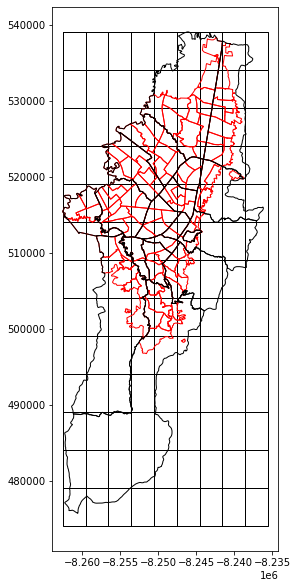

In [24]:
ax = polig_loc_df['geometry'].plot(figsize=(10,10), color='none', edgecolor='black', zorder=3)
poligonos_series.plot(ax=ax, edgecolor='black', color='none')
#cc_df['geometry'].plot(ax=ax, edgecolor='black', color='none')
vict_df['geometry'].plot(ax=ax, edgecolor='red', color='none')
#vict_df.plot(figsize=(10,10), color='none', edgecolor='red', zorder=3)

#poligonos_df['Poligono'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3, ax=ax)
#estrat_df['geometry'].plot(figsize=(10,10), color='none', edgecolor='blue', zorder=3, ax=ax)

# .plot(figsize=(10,10), color='none', edgecolor='red', zorder=1, ax=ax)
# .plot(figsize=(10,10), color='none', edgecolor='red', zorder=3, ax=ax)

#pq_esc_pub_df.plot(color='red', ax=ax, edgecolor='blue')